<a href="https://colab.research.google.com/github/BoringFinance/ML-HSGFS22-Submission/blob/main/ML_Submission_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###8,860,1.00: Coding Challenge Machine Learning FS22
University of St. Gallen \\
Boring Finance team \\
22 May, 2022

#1. Set Up

## 1.1 Download packages

At the very beginning, we import required packages and employ the GPU before trainning the model.

Import Rasterio, which is a package that reads and writes geospatial raster datasets.

In [1]:
import  sys 
!{ sys.executable } -m pip install rasterio

import rasterio as rio
from rasterio.plot import reshape_as_image

     |████████████████████████████████| 19.3 MB 453 kB/s 


Import functions to preprocess the data and train the neural network from PyTorch.

In [2]:
#import pytorch and related functions
import torch
import torch.nn as nn
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize
from torchvision.datasets import ImageFolder
from torchvision.transforms.transforms import ToPILImage

Import functions in Sklearn to split the validation set, and to generate the confusion matrix.

In [3]:
# import sklearn classification evaluation library
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import modules for processing data, getting time and plotting.

In [4]:
# import modules
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import copy

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

##1.2 Connect to Google Drive & Run on GPU

*Adapted from HSG-AIML-Teaching’s Course Code Lab: https://colab.research.google.com/github/HSG-AIML-Teaching/ML2022-Lab/blob/main/lab_3_5/colab_03-5.ipynb*

Import Google's GDrive connector and mount your GDrive directories.

In [5]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount('/content/drive')

Mounted at /content/drive


Create a structure of Colab Notebook sub-directories inside GDrive to store (1) the data as well as (2) the trained neural network models.

In [6]:
# create Colab Notebooks directory
notebook_directory = '/content/drive/MyDrive/Colab Notebooks'
if not os.path.exists(notebook_directory): os.makedirs(notebook_directory)

# create data sub-directory inside the Colab Notebooks directory
data_directory = '/content/drive/MyDrive/Colab Notebooks/data_eurosat_boringfinance'
if not os.path.exists(data_directory): os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
models_directory = '/content/drive/MyDrive/Colab Notebooks/models_eurosat_boringfinance'
if not os.path.exists(models_directory): os.makedirs(models_directory)

Set a random seed value to obtain reproducible results.

In [7]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

Enable GPU computing by setting the device flag and init a CUDA seed.

In [8]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


Let's determine if we have access to a GPU provided by e.g. Google's COLab environment.

In [9]:
!nvidia-smi

Sun May 22 16:40:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.3 Functions

Function to unzip file.

In [10]:
def unzip_file(zip_file, crt_dir, dst_dir):

  zFile = zipfile.ZipFile(crt_dir+"/"+zip_file, "r")

  for file in zFile.namelist(): 
    zFile.extract(file, dst_dir)
    
  zFile.close()

Function for normalization to range (0,1). \\
*Adapted from HSG-AIML-Teaching’s Course Code Lab: https://colab.research.google.com/github/HSG-AIML-Teaching/ML2022-Lab/blob/main/lab_3_5/colab_03-5.ipynb*

In [11]:
def normalize_for_display(band_data):

    band_data = np.array(band_data)

    # normalize with the 2- and 98-percentiles instead of minimum and maximum of each band
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    
    return (band_data - lower_perc) / (upper_perc - lower_perc)

Function for plotting distribution of images for 10 classes.

In [12]:
# plot the distribution of labels
def plot_label_dist(labels_set, title):
  
  # count the proportion of images of each label 
  labels_freq = []
  
  for cls in eurosat_classes:
    labels_freq.append(labels_set.count(cls) / len(labels_set))

  # plot the frequency
  freq_plot = plt.bar(x = range(10), height = labels_freq, width = 0.5, color = "skyblue", label = "Classes")

  plt.title(title)
  plt.ylabel("Frequency")
  plt.xticks(range(10), eurosat_classes, rotation = "vertical")

  plt.show()

Function for plotting pixel distributions within the classes.

In [13]:
def plot_image_dist(dataset, labels):

    n_images = len(dataset)
    #n_images = len(samples_train)

    rows = 3
    cols = 4

    fig = plt.figure(figsize = (15, 15))

    for i in range(10):
      count = 0
      count_num = 0
      for index in range(n_images):
        if labels[index] == i:
          new_count = dataset[index]
          count = np.append(count,new_count)
          count_num +=1
      ax = fig.add_subplot(rows, cols, i+1)
      plt.hist(count.ravel(), bins=50, density=True, range = [-2,2]);
      label = eurosat_classes[i]
      ax.set_title(label)

Function for plotting single image: with dataset, labels, and selected index as input.

In [14]:
def plot_single_image(input_data,input_labels,input_index):
  # a single image and label to plot
  img = input_data[input_index]
  label = input_labels[input_index]

  # plot
  fig, ax = plt.subplots(1, figsize=(5,5))
  ax.imshow(img.permute(1, 2, 0))
  ax.set_title(f"{label}")
  ax.axis(False)
  plt.tight_layout()
  plt.show()

Function for selecting image according to classes.

In [15]:
def image_selector(input_data,input_classes,input_labels):

  selected_image = []
  selected_label = []

  for index_class in range(len(input_classes)):
    for index_data in range(len(input_data)):
      # get the image and label if they match
      if input_labels[index_data] == index_class:
        selected_image.append(input_data[index_data])
        selected_label.append(input_labels[index_data])
        break
        
  return selected_image,selected_label

Function for selecting image according to test id.

In [16]:
def image_selector_test(input_data,num,input_id,random):
  
  selected_image_test = []

  if random:
    # random = True
    # select images randomly
    for idx in range(num):
      selected_image_test.append(input_data[idx])
      selected_id_test = input_id[:num]

    return (selected_image_test,selected_id_test)
    
  else:
    # select images sequentially
    for idx in range(0,num):
      for index in range(len(input_id)):
          if input_id[index] == idx:
            selected_image_test.append(input_data[index])
    selected_id_test = range(0,num)

    return (selected_image_test,selected_id_test)

Function for plotting multiple images: with images and labels as input. \\
*Adapted from amrzv’s ResNet Tutorial: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb*

In [17]:
def plot_images(images, labels, classes_boolean):

    n_images = len(images)

    if classes_boolean:
      rows = 3
      cols = 4
    else:
      rows = 4
      cols = 5

    fig = plt.figure(figsize = (15, 15))

    for i in range(n_images):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        if classes_boolean:
          label = eurosat_classes[labels[i]]
        else:
          label = labels[i]
        ax.set_title(label)
        ax.axis('off')

Functions for data augmentation, for the training set and the test set, separately.

In [18]:
# function to transform from array to tensor
trans_tensor = transforms.ToTensor()

# function for data augmentation
trans_train =  transforms.Compose([

        # enlarge the images by bilinear interpolation                       
        transforms.Resize([92,92]),                            

        # rotate the picture by the degree input
        transforms.RandomRotation(5),

        # filp by horizon
        transforms.RandomHorizontalFlip(0.5),

        # filp by vertical
        #transforms.RandomVerticalFlip(0.5),

        # pad the edges by 10 pixels
        transforms.RandomCrop(112, padding = 10),
        
        # normalize
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # given parameters

    ])

trans_val =  transforms.Compose([
                  # enlarge the images by bilinear interpolation
                  transforms.Resize([92,92]),
                  # cut the image from the center
                  transforms.CenterCrop(112),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ])    

trans_test =  transforms.Compose([
                  # enlarge the images by bilinear interpolation
                  transforms.Resize([92,92]),
                  # cut the image from the center
                  transforms.CenterCrop(112),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ])

Function to plot the range of learning rates and the corresponding train losses.

In [19]:
# plot the train loss against the learning rates
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

    return lrs[np.argmin(losses)], np.min(losses)

# 2. Download training data & split data

## 2.1 Download training data

### 2.1.1 Download EuroSAT.zip and unzip

The images in the EuroSAT are classified into 10 categories. Label the 10 categories from 0 to 9.

In [20]:
# define the labels
classes = {
    "AnnualCrop":0,
    "Forest":1,
    "HerbaceousVegetation":2,
    "Highway":3,
    "Industrial":4,
    "Pasture":5,
    "PermanentCrop":6,
    "Residential":7,
    "River":8,
    "SeaLake":9,
}
eurosat_classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"
]

Download the EuroSAT.

In [21]:
# download data from internet
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip

--2022-05-22 16:40:28--  https://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  19.6MB/s    in 1m 43s  

2022-05-22 16:42:12 (19.1 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



Unzip the file.

In [22]:
# working directory
crt = os.getcwd()
dst = crt + "/Eurosat"

filename = "EuroSATallBands.zip"

unzip_file(filename, crt, dst)

Match all images (.tif) and store them in the list, samples.

In [23]:
samples = glob.glob(os.path.join(dst+"/ds/images/remote_sensing/otherDatasets/sentinel_2/tif", "*", "*.tif"))

View the format of samples.

In [24]:
samples[0:9]

['/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_2976.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_1284.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_962.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_2050.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_2126.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_924.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_2771.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_1644.tif',
 '/content/Eurosat/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Forest/Forest_1402.tif']

### 2.1.2 Load training data

All images are downloaded and stored in the array samples now. Below copys the samples to run data preprocess.

In [25]:
# copy the samples for modification
import copy
samples_full = copy.deepcopy(samples)

Extract bands and labels from each images in samples, and normalize each band.


In this coding challenge, we focus on RGB bands for they have outstanding explantory power for most classes. 

Correspondingly, both the pretrained model and our ResNet50 have 3 input channels.

In [26]:
# select the bands to train the model
# RGB
bands = [3,2,1]
# get the number of bands
len_bands = len(bands)

# store the labels and samples of training data
labels = []

for idx in range(len(samples_full)):
  # loop on each image
  sample = samples_full[idx]

  # get the label
  labels.append(sample.split('/')[-1].split('_')[0])

  # get all bands
  samples_full[idx] = rio.open(sample, "r").read([1,2,3,4,5,6,7,8,9,10,11,12,13])

  # return the source array reshaped into the order expected by image processing and visualization 
  # from (bands, rows, columns) to (rows, columns, bands)
  samples_full[idx] = reshape_as_image(samples_full[idx])
  samples_full[idx] = np.array(samples_full[idx])

  # get the bands for training
  samples_full[idx] = samples_full[idx][:, :, bands]  

  # normalize the band values
  samples_full[idx] = normalize_for_display(samples_full[idx])

Let's check for the size of our training data and take one example to check the values of three bands at a certain pixel. 

In [27]:
# view one sample of normalized bands
print(len(samples_full))
print(samples_full[0][10,10,:])

27000
[0.7871321  0.9874477  0.75555556]


In addition, we plot the distribution of 10 classes in the whole EuroSAT.

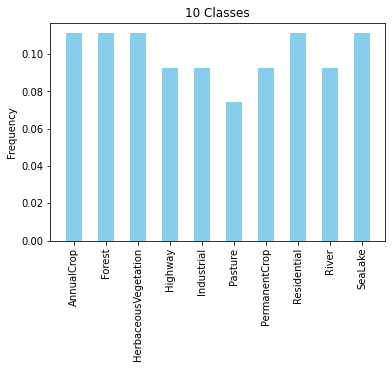

In [28]:
plot_label_dist(labels, "10 Classes")

We find that the training data are mostly balanced, while only the Pasture class has relatively smaller size.

##2.2 Split data to training/validation

### 2.2.1 With train-validation Split

We split the EuroSAT into the training set and the validation set firstly to test for the model fitness. 

The train_test_split function ensures that both the training set and the validation set have the same distribution as the original EuroSAT. 

Particularly, the split ratio is 0.2, meaning that there are 21600 images in the training set and 5400 in the validation set. Controlling random state equals to 0, we get the same training and validation set in every execution.

In [29]:
samples_split_train, samples_split_val, labels_split_train, labels_split_val = train_test_split(samples_full, labels, test_size=0.2, random_state=0)

Map the labels from text to index.

In [30]:
# map the labels
labels_split_train_index = [classes[labels_split_train[sample_idx]] for sample_idx in range(len(labels_split_train))]
labels_split_val_index = [classes[labels_split_val[sample_idx]] for sample_idx in range(len(labels_split_val))]

Get the number of images in the training and the validation set.

In [31]:
# get the number of images in the training set
len_split_train = len(samples_split_train)

# get the number of images in the validation set
len_split_val = len(samples_split_val)

# print the number of images
print("[LOG] The number of images in the training set: %d"% len_split_train)
print("[LOG] The number of images in the validation set: %d"% len_split_val)

[LOG] The number of images in the training set: 21600
[LOG] The number of images in the validation set: 5400


###2.2.2 Without train-validation Split

After finding the model with the best performance on the validation set, we assign the images and labels of the whole EuroSAT as input training set for our model.  

In [32]:
# assign the EuroSAT to the training variables by reference
samples_train = samples_full
labels_train = labels

Map the labels from text to index.

In [33]:
# map the labels
labels_train_index = [classes[labels_train[sample_idx]] for sample_idx in range(len(labels_train))]

Get the number of images in the training set.

In [34]:
# get the number of images in the training set
len_train = len(samples_train)

print("[LOG] The number of images in the training set: %d." % (len_train))

[LOG] The number of images in the training set: 27000.


#3. Data preprocessing - splitted data: training (80%) & validation

##3.1 Transform to tensor

Transform all the images in the training set to the class Tensor.

In [35]:
# training data
for idx in range(len_split_train):
   samples_split_train[idx] = trans_tensor(samples_split_train[idx])

# validation data
for idx in range(len_split_val):
   samples_split_val[idx] = trans_tensor(samples_split_val[idx])

##3.2 Visualization | Non-Augmentation

###3.2.1 Visualize single training data | Non-augmentation

Let's view the images in the training set to get a first impression. First, we choose a single image to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


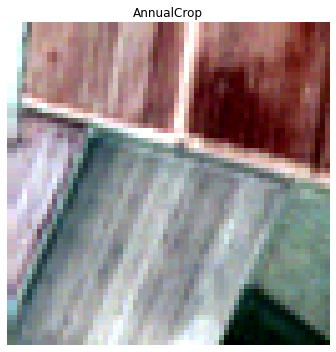

In [36]:
# plot a single image
plot_single_image(samples_split_train,labels_split_train,42)

### 3.2.2 Visualize multiple training data | Non-augmentation

Then let's plot one sample for each of the 10 classes together and compare them.

Select images from training set to plot.

In [37]:
selected_image_train_noaug = image_selector(samples_split_train,classes,labels_split_train_index)[0]
selected_label_train_noaug = image_selector(samples_split_train,classes,labels_split_train_index)[1]

Plot the images of each class randomly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

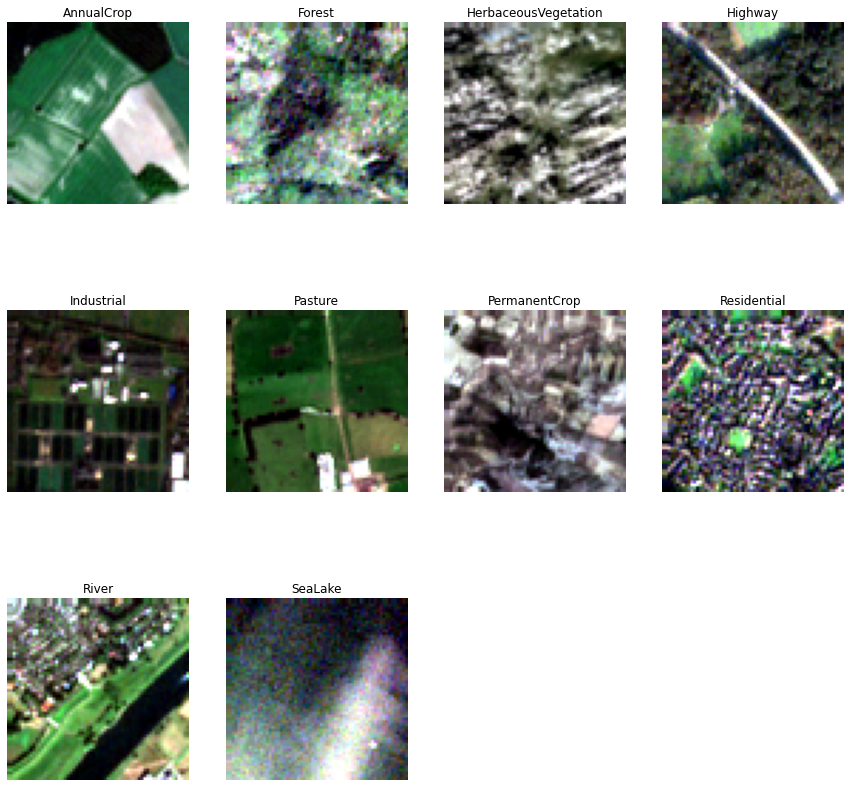

In [38]:
plot_images(selected_image_train_noaug,selected_label_train_noaug,True)

Intuitively, we find the classes in these following subsets are similar:

- Pasture, AnnualCrop, PermenantCrop
- Forest, HerbaceousVegetation
- Highway, River
- Industrial, Residential
- Sealake

###3.2.3 Visualize single validation data | Non-augmentation

Similarly, we choose a single image in the validation set to view.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


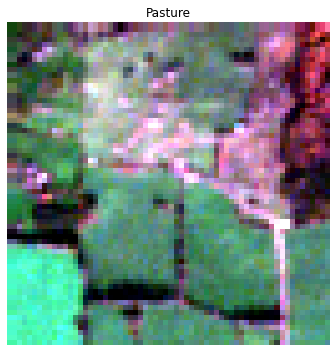

In [39]:
# plot a single image
plot_single_image(samples_split_val,labels_split_val,42)

### 3.2.4 Visualize multiple validation data | Non-augmentation


Plot one sample for each of the 10 classes together and compare them.

Select images from validation set to plot.

In [40]:
selected_image_test_noaug = image_selector(samples_split_val,classes,labels_split_val_index)[0]
selected_label_test_noaug = image_selector(samples_split_val,classes,labels_split_val_index)[1]

Plot the images of each class randomly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

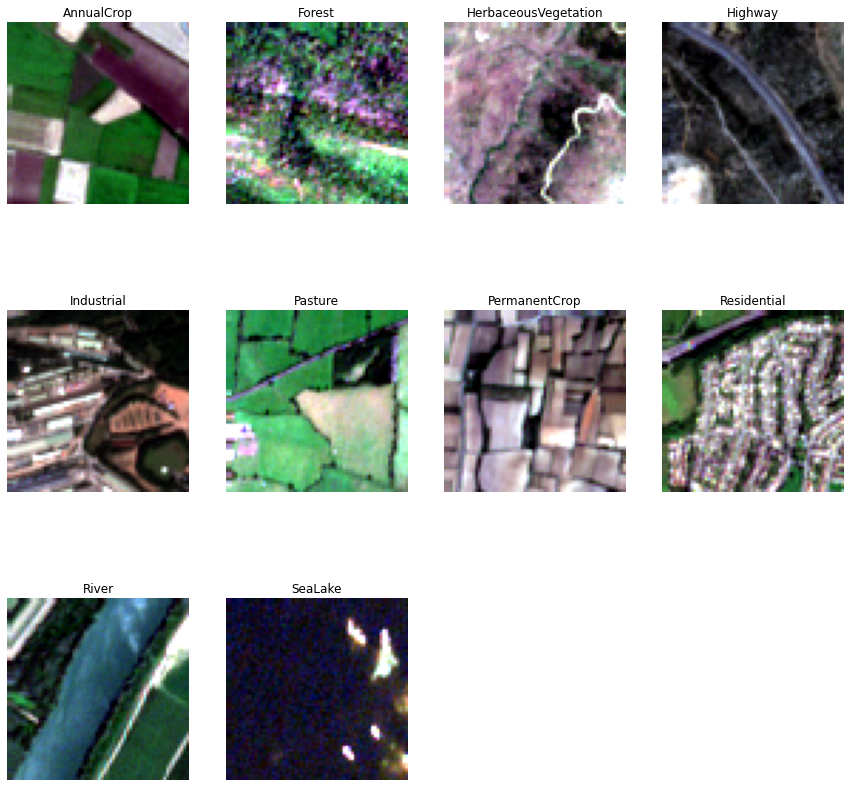

In [41]:
plot_images(selected_image_test_noaug,selected_label_test_noaug,True)

Visually, the samples in the validation set are simiiar to those in the training set correspondingly. 

##3.3 Data Augmentation

Data augmentation is a technique to increase the size of dataset by applying slight transformation to the original data. Applying the data augmentation can deal with the problem of insufficient training data and uneven class balance in machine learning. More, this techinique increases the robustness of the neural network to resist the adversarial attacks (Mikołajczyk and  Grochowski, 2018). 

Numerous data augmentation techniques can be classified into two categories: traditional, white-box methods or black-box methods based on deep neural networks (Mikołajczyk and Grochowski, 2018). As a try to improve our model's performance, we employ the traditional ones of affine and elastic transformations, which are effective and reasonable intuitively to diversify our dataset while not distort the features excessively.

Pytorch offers a module, transforms, to apply common data augmentations to PIL images and tensors. The random applications are implemented when training the model. Huang(2019) shows how the random transformation is called in PyTorch: 

<img src="https://drive.google.com/uc?export=view&id=1bU9wxyGF6jFW3z4zk8Dk3GEPC943n6q0" width="400" height="200" />

Call Procedure of .transforms in PyTorch. &nbsp; Source: Choles Huang, Blog

Below we try the flips and rotations on EuroSAT.

For the training set, in terms of the affine transformations, we add random rotation with a degree of 5, as well as random horizontal and vertical flips with the probability of 5 to the pictures in the training set.

For both of the training and the validation set, firstly, we enlarge the pictures to the size of 92×92, and then, we pad it with zero borders of 10 pixels, making the pictures to 112×112 finally. 

The size transformations are made out of this two concerns:
  - There might be features at the edge of images, which can be missed by the kernels when scanning without padding.
  - The ResNet50 model in PyTorch follows the classical structure that preprocess all images to 224×224 at the beginning of training. Resizing the data perviously may make the images fit the ResNet50 model better.

In addition, we normalize the RGB band with the means and standard deviations given by Pytorch generated from ImageNet dataset.

Below assign the transform function to each tensor.

In [42]:
# training data
for idx in range(len(samples_split_train)):
  samples_split_train[idx] = trans_train(samples_split_train[idx])

# validation data
for idx in range(len(samples_split_val)):
  samples_split_val[idx] = trans_val(samples_split_val[idx])

##3.4 Visualization | Augmentation

### 3.4.1 Visulize single training data | Augmentation

Let's have a look at how our images changed visually after data augmentation. First, we plot a single image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


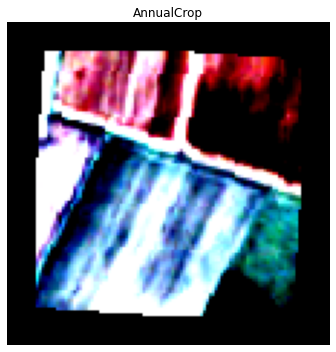

In [43]:
plot_single_image(samples_split_train,labels_split_train,42)

### 3.4.2 Visualize multiple training data | Augmentation

Plot images of each class after augmentation. 

In [44]:
selected_image_train_aug = image_selector(samples_split_train,classes,labels_split_train_index)[0]
selected_label_train_aug = image_selector(samples_split_train,classes,labels_split_train_index)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

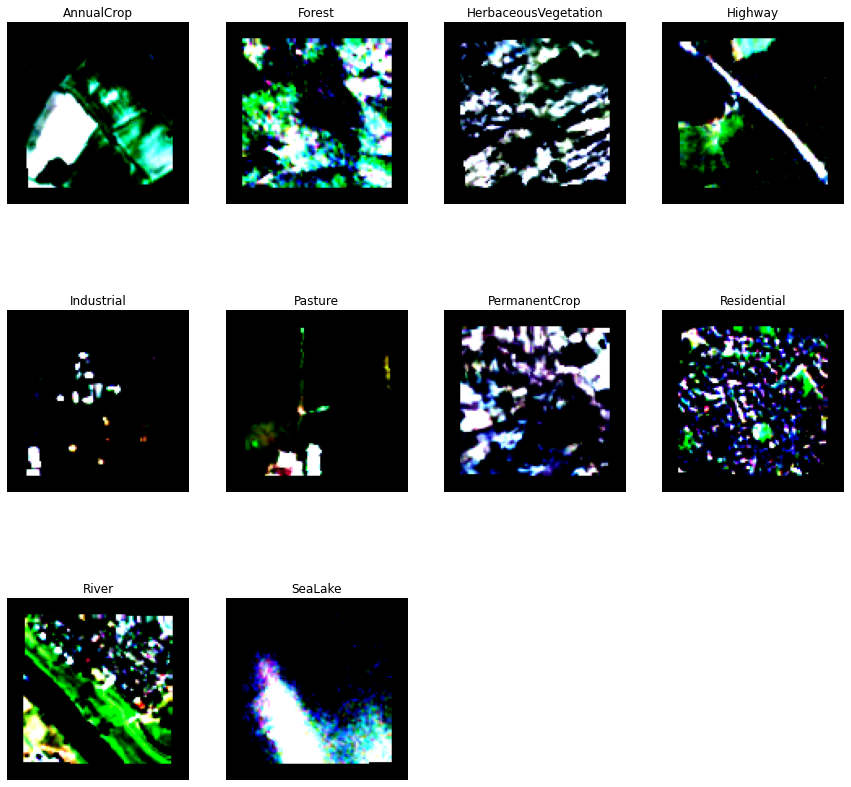

In [45]:
plot_images(selected_image_train_aug,selected_label_train_aug,True)

We find that the data augmentation increases the contrast among RGB bands and the diversity of the images, while keep most of the features like the shapes and the borders in our images.

### 3.4.3 Visulize single validation data | Augmentation

For the validation data, we only employ the normalize method, same as which for the training set. 

View a single image after data augmentation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


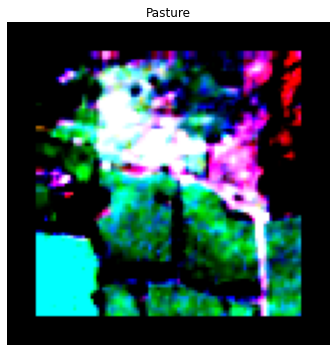

In [46]:
plot_single_image(samples_split_val,labels_split_val,42)

### 3.4.4 Visualize multiple validation data | Augmentation

Plot images of each class after augmentation. 

In [47]:
selected_image_val_aug = image_selector(samples_split_val,classes,labels_split_val_index)[0]
selected_label_val_aug = image_selector(samples_split_val,classes,labels_split_val_index)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

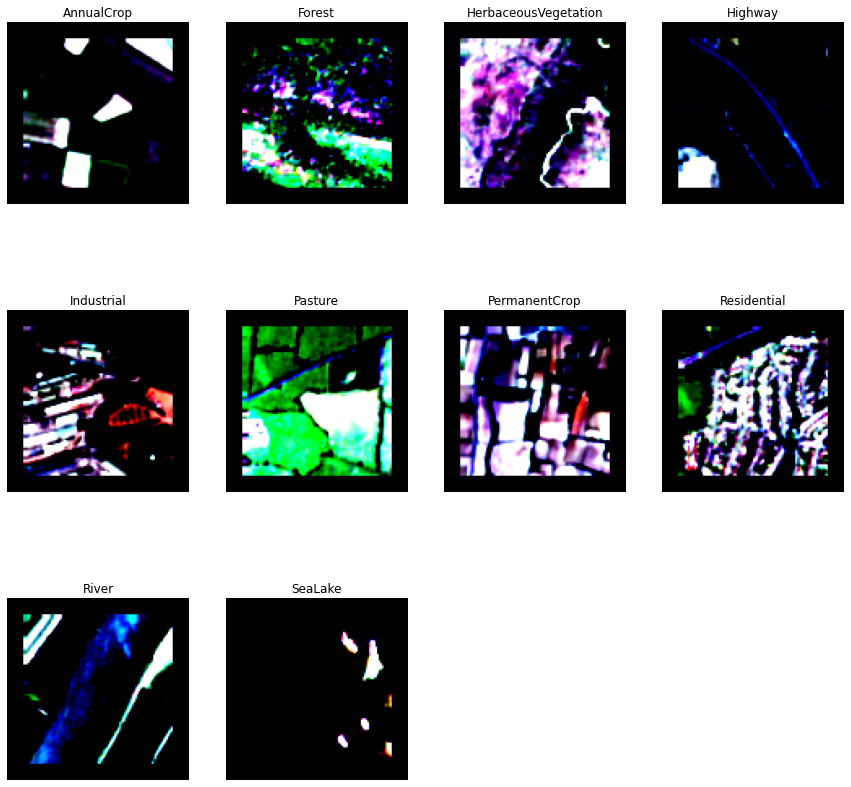

In [48]:
plot_images(selected_image_val_aug,selected_label_val_aug,True)

# 4. Download & load test data

## 4.1 Download test data from Kaggle

Download the Kaggle API Credential from Xuemei Jiang's Google Drive:

In [49]:
!gdown --id "1WR4fPtFENaoE4P_EVYLSs6_bPXcqgqxT"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1WR4fPtFENaoE4P_EVYLSs6_bPXcqgqxT
To: /content/kaggle.json
100% 67.0/67.0 [00:00<00:00, 143kB/s]


Install the kaggle library.

In [50]:
! pip install kaggle

Make a directory called ".kaggle". 

In [51]:
!mkdir -p ~/.kaggle/

Copy the "kaggle.json" file to the directory ".kaggle".

In [52]:
! cp kaggle.json ~/.kaggle/

Allocate the required permission.

In [53]:
! chmod 600 ~/.kaggle/kaggle.json

Download data from Kaggle Compeitition: https://www.kaggle.com/competitions/aiml-coding-challenge-fs22

In [54]:
! kaggle competitions download -c aiml-coding-challenge-fs22

 92% 278M/303M [00:01<00:00, 257MB/s]
100% 303M/303M [00:01<00:00, 266MB/s]


## 4.2 Load test data

Unzip test data.

In [55]:
# working directory
crt = os.getcwd()
dst = crt + "/Eurosat_test"
filename = "aiml-coding-challenge-fs22.zip"

# unzip file
unzip_file(filename, crt, dst)

Load test data to the list called `samples_test`. `samples_test` have 4232 images.

In [56]:
# unzip test sampls from .zip file
testset_dir = os.path.join(dst, "testset/testset")
samples_test = glob.glob(os.path.join(testset_dir, "*.npy"))
len(samples_test)

4232

Show the first 10 .npy files in the `samples_test` list.

In [57]:
samples_test[0:9]

['/content/Eurosat_test/testset/testset/test_3782.npy',
 '/content/Eurosat_test/testset/testset/test_3909.npy',
 '/content/Eurosat_test/testset/testset/test_3596.npy',
 '/content/Eurosat_test/testset/testset/test_1634.npy',
 '/content/Eurosat_test/testset/testset/test_3983.npy',
 '/content/Eurosat_test/testset/testset/test_2114.npy',
 '/content/Eurosat_test/testset/testset/test_1154.npy',
 '/content/Eurosat_test/testset/testset/test_3126.npy',
 '/content/Eurosat_test/testset/testset/test_2094.npy']

Deepcopy the test samples to preprocess and run the prediction.

In [58]:
# get a copy of test samples
samples_test_full = copy.deepcopy(samples_test)

We do not have the labels for Kaggle data, hereby we take the ids of the samples to list the predictions in the .csv file.

In [59]:
# get the index of test samples
test_id = []
for index in range(len(samples_test_full)):
  test_id.append(samples_test_full[index].split('_')[-1].split('.npy')[0])

test_id = [int(x) for x in test_id]
print(test_id[0:9])

[3782, 3909, 3596, 1634, 3983, 2114, 1154, 3126, 2094]


Correspondingly to the training set, we get the same RGB bands for the test samples and normalize the test samples to display. 

In [60]:
# normalize and get bands that are same as the train sample's
for idx in range(len(samples_test_full)):
  samples_test_full[idx] = np.load(samples_test_full[idx])
  samples_test_full[idx] = samples_test_full[idx][:, :, bands]
  samples_test_full[idx] = normalize_for_display(samples_test_full[idx])

Double check for the total number of the test samples, and each sample's shape in the test set. 

In [61]:
# check the total number
print(len(samples_test_full))

# check the shape
print(samples_test_full[0].shape)

4232
(64, 64, 3)


#5. Data preprocessing - training (100%) & test

## 5.1 Transform to tensors

As in the section 2, we preprocess the test data following the same procedure to the validation data.

In [62]:
# training data
for idx in range(len(samples_train)):
   samples_train[idx] = trans_tensor(samples_train[idx])

for idx in range(len(samples_test_full)):
   samples_test_full[idx] = trans_tensor(samples_test_full[idx])

Plot sample image from the training set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


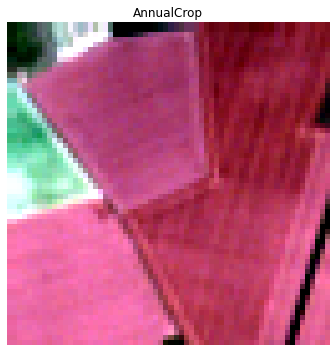

In [63]:
plot_single_image(samples_train,labels_train,14562)

Visualize the distriution of images for each class before data augmentation.

In [64]:
# The following line is commented to save time. This cell will take roughly 15 mins to run.
# plot_image_dist(samples_train,labels_train_index)

## 5.2 Visualization | Non-Augmentation

### 5.2.1 Visulize single test data | Non-Augmentation

Here we show the selected single image of the test data. The number in the `plot_single_image` function can be selected from 0 to 4231. \\
Above the image, the test id of the image is shown as well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


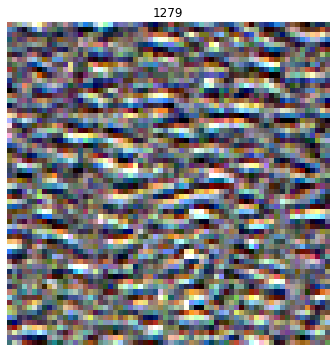

In [65]:
plot_single_image(samples_test_full,test_id,42)

### 5.2.2 Visulize multiple test data | Non-Augmentation

Select 20 images from random test id.

In [66]:
num = 20
selected_test_image = image_selector_test(samples_test_full,num,test_id,True)[0]
selected_test_id = image_selector_test(samples_test_full,num,test_id,True)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

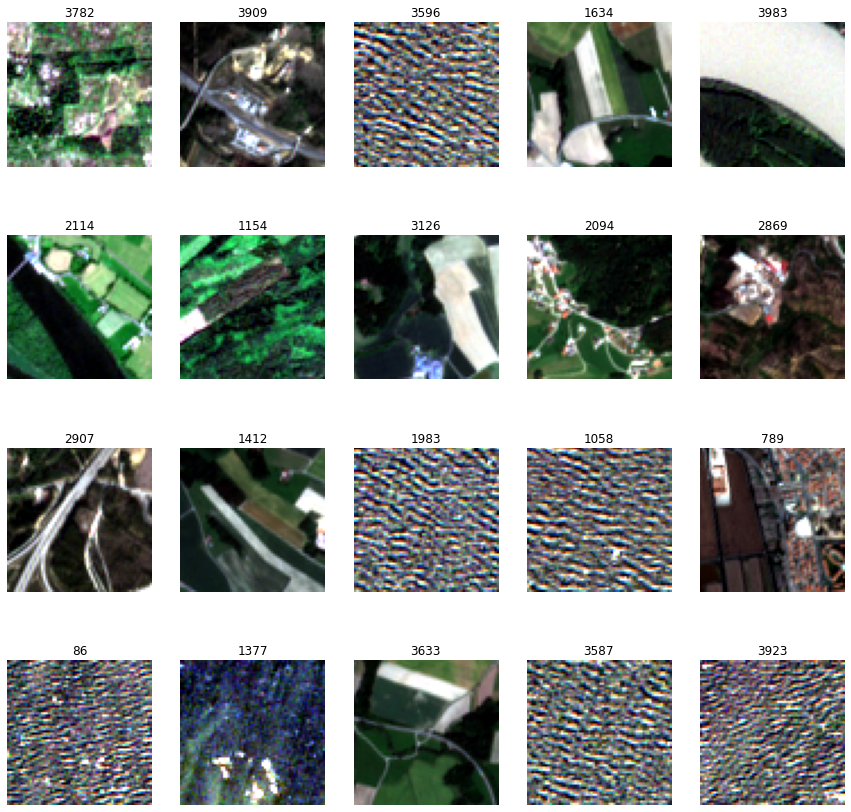

In [67]:
plot_images(selected_test_image,selected_test_id,False)

## 5.3 Data Augmentation

Apply the same augmentation procedures for the 100% training and the test data as that those for the 80% training and the validation data.

In [68]:
# training data
for idx in range(len(samples_train)):
   samples_train[idx] = trans_train(samples_train[idx])

# test data
for idx in range(len(samples_test_full)):
   samples_test_full[idx] = trans_test(samples_test_full[idx])

View a single image in the training set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


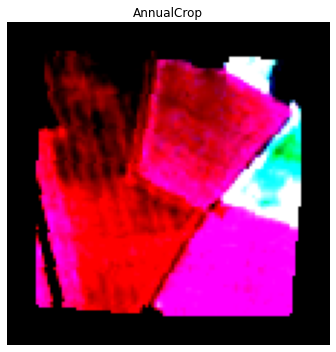

In [69]:
plot_single_image(samples_train,labels_train,14562)

Visualize the distriution of images for each class after data augmentation.

In [70]:
# The following line is commented to save time. This cell will take roughly 55 mins to run.
# plot_image_dist(samples_train,labels_train_index)

## 5.4 Visualization | Augmentation

### 5.4.1 Visulize single test data | Augmentation

View a single image in the test data from Kaggle.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


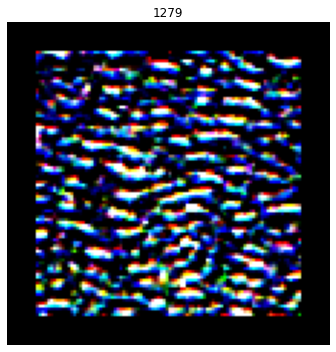

In [71]:
plot_single_image(samples_test_full,test_id,42)

### 5.4.2 Visulize multiple test data | Augmentation

Select 20 images from random test id to plot.

In [72]:
num = 20
selected_test_image = image_selector_test(samples_test_full,num,test_id,True)[0]
selected_test_id = image_selector_test(samples_test_full,num,test_id,True)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

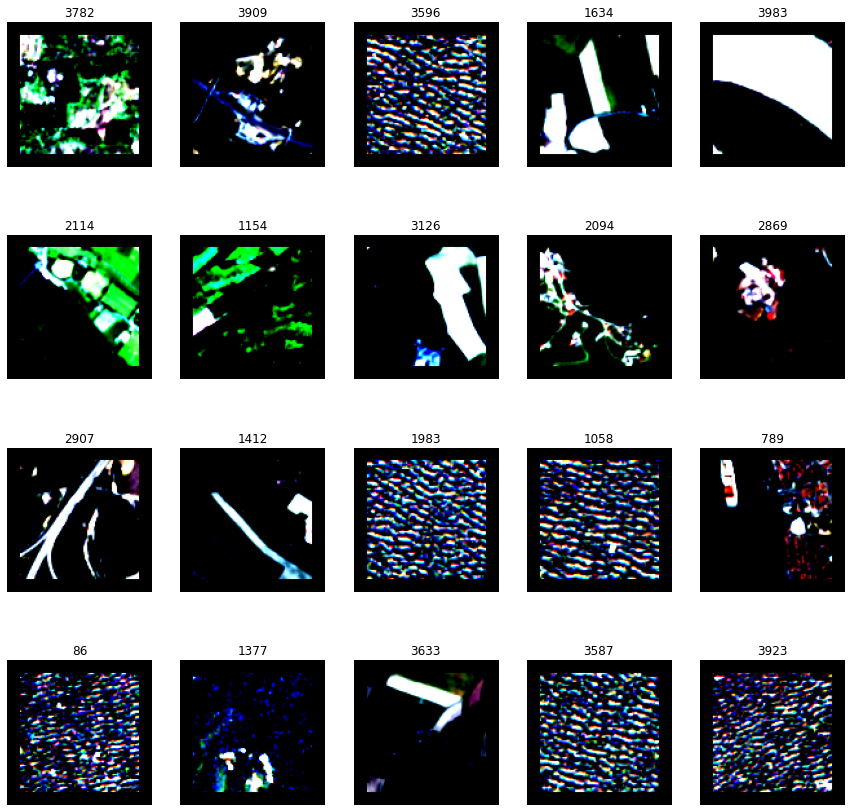

In [73]:
plot_images(selected_test_image,selected_test_id,False)

# 6. Assign value to Eurosat data

Splitted data: training (80%) & validation: 

In [74]:
# training set(80%)
eurosat_split_train = [(samples_split_train[sample_idx], labels_split_train_index[sample_idx]) for sample_idx in range(len(labels_split_train_index))]

# test set(20%)
eurosat_split_val = [(samples_split_val[sample_idx], labels_split_val_index[sample_idx]) for sample_idx in range(len(labels_split_val_index))]

In [75]:
print(eurosat_split_train[0][0].shape)
print(eurosat_split_val[0][0].shape)

torch.Size([3, 112, 112])
torch.Size([3, 112, 112])


Training (100%) & test:

In [76]:
# the training set
eurosat_train = [(samples_train[sample_idx], labels_train_index[sample_idx]) for sample_idx in range(len(labels_train_index))]

# the test set
eurosat_test = samples_test_full

In [77]:
print(eurosat_train[0][0].shape)
print(eurosat_test[0].shape)

torch.Size([3, 112, 112])
torch.Size([3, 112, 112])


# 7. **Model training**

## 7.1 Model: Pretrained ResNet50

### 7.1.1 ResNet50

- ResNet

When seeking to increase the depth of neural networks, one problem is degradation, meaning that as the network depth increases after a certain degree, the accuracy rapidly degrades. He et al. (2016) present a residual network framework to deal with this degradation problem by shifting to learn the residual and adding a shortcut structure. 

The key improvement in the ResNet is that it employs the mapping $𝓕(x):=𝓗(x) - x $ to learn the residuals. In the worst case, this network will push the residual to zero to fit an identical mapping, which let the deep network performs at least as well as the structure without this layer. In programming, this shortcut design is realized by adding residual blocks, `BasicBlock` or `Bottleneck`. 

<img src="https://raw.githubusercontent.com/BoringFinance/ML-HSGFS22-Submission/main/Figures/resnet.png" width="400" height="400" />

Source: Machine Learning, Lecture Slides, HSG

There are numerous studies about the explanation of this improvement. One explaination is that the nonlinear ReLU layer can result in information loss to deeper layers. Another is that approximating the original functions are harder to pass the layer compared with the identity functions. Balduzzi et al. (2017) also presents a new idea that the correlation between gradients in plain networks decays with increasing depth, resulting in leaving white noise, while the skip connections resist this problem well.

As we find that shallow CNN performs not well in predicting the validation set as well as the Kaggle images, we think about deepening our neural network and shift to the ResNet.

- ResNet50

<img src="https://raw.githubusercontent.com/BoringFinance/ML-HSGFS22-Submission/main/Figures/resnet50.png" width="800" height="400" />

Source: He et al. (2016)

He et al. (2016) present the 5 classical setups for ResNet. These networks share the following common points:
  - Each network has 5 layers
    - Constructed by convolutions, batch-normalizations, ReLu, poolings, basic blocks and bottlenecks
  - Each layer executes a downsampling
    - Reduce the length of the image side by half
    - Reduce the size of the image by 1/4
  - The $1^{st}$ layer requires:
    - The same input image size of 224×224
    - The same kernel size of 7×7
    - The same stride of 2
    - The same output size of 112×112
    - Followed with a maxpooling operation
  - The following 4 sets of layers contains several similar basic blocks or bottlenecks
  - End with an average pooling and linear fully connection layer

Particularly, ResNet50 employs the bottleneck architecture, having 3, 4, 6 and 3 bottlenecks from the $2^{nd}$ to the $5^{th}$ set of layers, with the output channels of 256, 512, 1024 and 2048, respectively. In each bottleneck, 3 convolutions are implemented; with the addtion of the one in the $1^{st}$ layer, the ResNet50 has $3×(3+4+6+3)+1=49$ convolutional layers; plus the fully connection layer in the end, in total, the ResNet50 has 50 layers, as the name indicates.

Here, we choose ResNet50 as the fundamental network for our pretrained model, under the consideration of balancing the network depth and the training efficiency. 

Define the ResNet50 architecture. \\
*The architecture is adapted from amrzv’s ResNet Tutorial: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb*

In [78]:
# implement the resnet50
class ResNet(nn.Module):

    def __init__(self, config, output_dim):

        super().__init__()

        # set the block type
        # number of blocks and number of channels in each layer as lists
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4 # corresponding to 4 layers
        
        # init initial convolutional layer
        self.conv1 = nn.Conv2d(len_bands, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        
        # the batch normalization here and below
        # are to solve the vanishing and exploiding gradients
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # the first to the forth residual layer
        # blocks: block type, n_blocks[]: number of blocks in each layer, channels: input channels of each layer
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        # average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        # fully connection output
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    # the function to set each residual layer
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
        # store the layer structure
        layers = []
        
        if self.in_channels != block.expansion * channels:
          # down sampling needed
            downsample = True
        else:
          # no down sampling
            downsample = False
        
        # initial residual block
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        # add the following block with expansion
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))
        
        # reset input channels
        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)

    # the function to define the forward pass
    def forward(self, x):
        
        # run through inital layer
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # run through 4 residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # average pooling and fully connection
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

- Residual Blocks

<img src="https://raw.githubusercontent.com/BoringFinance/ML-HSGFS22-Submission/main/Figures/residual_block.png" width="500" height="200" />

Source: He et al.(2016), left: the basic block; right: the bottleneck 

Residual blocks capsulate the similar convolution, batch normalization and ReLU operation to be repeated. The key improvement, shortcuts, are executed at the end of each block. 

More precisely, there are two types of residual blocks, **identity** and **projection**, which are generally referred to as the `BasicBlock` and the `Bottleneck` in the residual network settings. 

The basic block has 2 convolutional layers with the same kernel size of 3, while the bottleneck has a 1×1 convolutional layers in the front and the end. The two 1×1 layers are designed to reduce the parameters in the middle layer by reducing and restoring the dimensions. 

Compared with the basic block, the bottleneck structure effectively reduces the number of parameters and the heavy computation, hereby is widely used in deeper neural networks. 

Define the basic block architecture. 

In [79]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        # init first convolutional layer of residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)

        # init second convolutional layer of residual block     
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # init relu
        self.relu = nn.ReLU(inplace = True)
        
        if downsample: 
            # convolution downsample for changing dimension by changing the stride
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        # i indicates the residual
        # x is used for forward passing and generating output
        # determine the residual
        i = x
        
        # run forward pass through first layer, with bn and relu
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # run forward pass through second layer, with bn and no relu before shortcut
        x = self.conv2(x)
        x = self.bn2(x)
        
        # downsample check
        if self.downsample is not None:
            i = self.downsample(i)

        # SHORTCUT
        # must firstly connect the residual     
        x += i
        # the apply the ReLU
        # otherwise the model does not converges
        x = self.relu(x)
        
        return x

Define the bottleneck architecture.

In [80]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        # init first convolutional layer of residual block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # init second convolutional layer of residual block 
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # init third convolutional layer of residual block
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        # init relu
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            # convolution downsample for changing dimension by changing the stride
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        # i indicates the residual
        # x is used for forward passing and generating output
        # determine the residual
        i = x
        
        # run forward pass through first layer, with bn and relu
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # run forward pass through second layer, with bn and relu
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        # run forward pass through third layer, with bn and no relu before shortcut
        x = self.conv3(x)
        x = self.bn3(x)
                
        # downsample check
        if self.downsample is not None:
            i = self.downsample(i)
            
        # SHORTCUT
        # must firstly connect the residual     
        x += i
        # then apply the ReLU
        # otherwise the model does not converges
        x = self.relu(x)
    
        return x

Set the configurations of ResNet50.

In [81]:
# set names
from collections import namedtuple
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [82]:
# set configuration values
resnet50_config = ResNetConfig(block = Bottleneck,
                n_blocks = [3, 4, 6, 3],
                channels = [64, 128, 256, 512])

#resnet101_config = ResNetConfig(block = Bottleneck,
                #n_blocks = [3, 4, 23, 3],
                #channels = [64, 128, 256, 512])

#resnet152_config = ResNetConfig(block = Bottleneck,
                #n_blocks = [3, 8, 36, 3],
                #channels = [64, 128, 256, 512])

###7.1.2 Pre-trained model

Tranfer learning from pre-trained model has several advantages (Marcelino, 2018): \\


1.   It allows us to build a more accurate model. With transfer learning, it is possible to load the pre-trained model (for example, pre-trained ResNet50 model) before training on our own dataset. The pre-trained model selected should be trained on a similar benchmark dataset (for example, ImageNet) and is to solve the problem similar to ours.
2.   It allows to save the training time. There are three strategies to fine-tune the pre-trained model:

> *   Train the entire model: 
> *   Train some layers and leave the other layers frozen / fine-tuning;
> *   Only replace the classifier and free the convolutional layer. \\
 <img src="https://raw.githubusercontent.com/BoringFinance/ML-HSGFS22-Submission/main/Figures/pretrained_model_strategy.png" width="1000" height="500" /> \\
Pre-trained model tuning strategy (Marcelino, 2018)

In our case, we train the entire model while starting from the parameters loaded from the pre-trained model.







Load the pre-trained ResNet50 model.

In [83]:
from torchvision import models
pretrained_model = models.resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Create a new linear layer with different output dimension: 10 classes.

In [84]:
in_features = pretrained_model.fc.in_features 
output_dim = len(classes)

fc = nn.Linear(in_features, output_dim)

Replace the linear layer of the pretrained model with our new linear layer.

In [85]:
pretrained_model.fc = fc

Check: the output classes should be 10 classes.

In [86]:
print(output_dim)

10


## 7.2 Model training on Training(80%) - Validation (20%)

### 7.2.1 Set up model, hyperparameters and functions

Initiate our ResNet50 model.

In [87]:
resnet_model = ResNet(resnet50_config, output_dim)

Copy the parameters of the pretrained ResNet50 model to our architecture.

In [88]:
resnet_model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

Load the ResNet50 model to device.

In [89]:
resnet_model = resnet_model.to(device)

Print the initialized architectures.

In [90]:
# print the initialized architectures
print('[LOG] ResNet architecture:\n\n{}\n'.format(resnet_model))

[LOG] ResNet architecture:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ker

- Loss Functions

In Pytorch, the following three loss functions are capsulated to be used in multi-class classification
tasks widely:

- Negative Log-Likelihood Loss, `torch.nn.NLLLoss`

$$NLL: ℒ(x,y) = {l_1, ..., l_N}^{T}, l_n = - 𝑤_{y_n} x_{n, y_n}$$

  The NLL input is expected to contain log-probabilities of each class, which can be down by adding the log-probabilities softmax at the end of the model. The NLL punishes for making correct predictions with smaller probabilities, and encourages for making predictions with higher probabilities.


- Kullback-Leibler Divergence, `torch.nn.KLDivLoss`

$$KLD: ℒ(x,y) = y_{true} (log(y_{true}) - x_{predict})$$
      
  KL Divergence tells the proximity of two probability distributions. It only assess how the probability distribution prediction is different from the distribution of ground truth.


- Cross-Entropy Loss, `torch.nn.CrossEntropyLoss`
    
$$CrossEntropyLoss: ℒ(x,y) = {l_1, ..., l_N}^{T}, l_n = - 𝑤_{y_n} log \dfrac{exp(x_{n, y_n})}{\Sigma_{c=1}^{C} exp(x_{n, c})}·1$$

Cross-Entropy punishes incorrect but confident as well as correct but inconfident predictions. Unlike the NLL, the Cross-Entropy punishments are based on confident level.

Note that, in Pytorch, the `torch.nn.CrossEntropyLoss` automatically calls a softmax function before calculating the loss. When setting the `reduction` parameter as 'mean' by default, the functions is equivalent to the combination of `LogSoftmax` and `NLLLoss` (PyTorch, documentations).


Here we use the default mode of Cross-Entropy Loss. Define the loss function and load the loss function to device.

In [91]:
# define the loss function

nll_loss = nn.CrossEntropyLoss()
nll_loss = nll_loss.to(device)

By try and error, we find that the mini batch size is suitable to be around 20 to 80, for balancing the accuracy and stability of the predictions. Under this setting, according to the train loss line graph after training, setting the number of epochs to be 20 let the train loss reduce to an ideally low level.

Define epochs and batch size.

In [92]:
# number of training epochs
num_epochs = 20 

# size of the mini-batches
mini_batch_size = 32

Define learning rate and optimizer.

In [93]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=resnet_model.parameters(), lr=learning_rate)

Show number of parameters.

In [94]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in resnet_model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained ResNet model parameters: {}.'.format(num_params))

[LOG] Number of to be trained ResNet model parameters: 23528522.


### 7.2.2 Load training data to dataloader

Load the splitted training data (80%) to `eurosat_train_split_dataloader`.

In [95]:
# automatic batching
eurosat_train_split_dataloader = torch.utils.data.DataLoader(eurosat_split_train, batch_size=mini_batch_size, shuffle=True)

# check the total number of batches
print("[LOG] Total number of batches in the dataloader: %d" %len(eurosat_train_split_dataloader))

[LOG] Total number of batches in the dataloader: 675


### 7.2.3 Model training

Function to train ResNet50 model: \\


*   Input: dataloader, loss function, optimizer, number of epochs;
*   Output: trained model epoch saved to model directory. \\

*Model training process is adapted from HSG-AIML-Teaching’s Course Code Lab: https://colab.research.google.com/github/HSG-AIML-Teaching/ML2022-Lab/blob/main/lab_3_5/colab_03-5.ipynb*



In [96]:
def training_model(dataloader,loss_function,optimizer_name,epochs):

  optimizer = optimizer_name
  num_epochs = epochs
  nll_loss = loss_function

  # set the model in training mode
  resnet_model.train()

  # train the resnet model
  for epoch in range(num_epochs):
      
      # init collection of mini-batch losses
      train_mini_batch_losses = []
      
      # iterate over all-mini batches
      for i, (images, labels) in enumerate(dataloader):
          
          # push mini-batch data to computation device
          images = images.to(device)
          labels = labels.to(device)

          # run forward pass through the network
          output = resnet_model(images.float())
          
          # reset graph gradients
          resnet_model.zero_grad()
          
          # determine classification loss
          loss = nll_loss(output[0], labels)
          
          # run backward pass
          loss.backward()
          
          # update network paramaters
          optimizer.step()
          
          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())
          
          # print mini-batch loss
          now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
          #print('[LOG {}] epoch: {}, batch: {} train-loss: {}'.format(str(now), str(epoch+1), str(i+1), str(loss.item())))

      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)
      
      # print epoch loss
      now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
      print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch+1), str(train_epoch_loss)))

      # set filename of actual model
      model_name = 'EUROSAT_model_epoch_{}.pth'.format(str(epoch))

      # save current model to GDrive models directory
      torch.save(resnet_model.state_dict(), os.path.join(models_directory, model_name))
      
      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

Function to plot epoch losses.

In [97]:
def plot_epoch_losses(epoch_losses):

  train_epoch_losses = epoch_losses

  # prepare plot
  fig = plt.figure()
  ax = fig.add_subplot(111)

  # add grid
  ax.grid(linestyle='dotted')

  # plot the training epochs vs. the epochs' classification error
  ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

  # add axis legends
  ax.set_xlabel("[training epoch $mb_i$]", fontsize=10)
  ax.set_ylabel("[Classification Error $\mathcal{L}^{NLL}$]", fontsize=10)

  # set plot legend
  plt.legend(loc="upper right", numpoints=1, fancybox=True)

  # add plot title
  plt.title('Training Iterations $mb_i$ vs. Classification Error $L^{NLL}$', fontsize=10);

Start training and save the epoch losses to `train_epoch_losses`.

In [98]:
# create a list to save loss in each epoch
train_epoch_losses = []

# start training
training_model(eurosat_train_split_dataloader,nll_loss,optimizer,num_epochs)

[LOG 20220522-16:47:17] epoch: 1 train-loss: 1.0337979754695186
[LOG 20220522-16:48:07] epoch: 2 train-loss: 0.34410503991224145
[LOG 20220522-16:48:53] epoch: 3 train-loss: 0.24451734076495524
[LOG 20220522-16:49:38] epoch: 4 train-loss: 0.1950394140349494
[LOG 20220522-16:50:23] epoch: 5 train-loss: 0.16434034443149964
[LOG 20220522-16:51:09] epoch: 6 train-loss: 0.1289246837173899
[LOG 20220522-16:51:54] epoch: 7 train-loss: 0.11819274949668734
[LOG 20220522-16:52:42] epoch: 8 train-loss: 0.09694411294465816
[LOG 20220522-16:53:27] epoch: 9 train-loss: 0.0852479145227483
[LOG 20220522-16:54:12] epoch: 10 train-loss: 0.07497176673194325
[LOG 20220522-16:54:59] epoch: 11 train-loss: 0.06617118417043928
[LOG 20220522-16:55:44] epoch: 12 train-loss: 0.05727359492745664
[LOG 20220522-16:56:30] epoch: 13 train-loss: 0.047118593505411234
[LOG 20220522-16:57:15] epoch: 14 train-loss: 0.041302516498016535
[LOG 20220522-16:58:00] epoch: 15 train-loss: 0.03876806351666649
[LOG 20220522-16:58:4

Print the losses in each epoch.

In [99]:
# get the train loss
train_epoch_losses

# print the losses
i = 1
for item in train_epoch_losses:
  print(f"[LOG]: The train-loss for epoch {i} is {item}.")
  i +=1

[LOG]: The train-loss for epoch 1 is 1.0337979754695186.
[LOG]: The train-loss for epoch 2 is 0.34410503991224145.
[LOG]: The train-loss for epoch 3 is 0.24451734076495524.
[LOG]: The train-loss for epoch 4 is 0.1950394140349494.
[LOG]: The train-loss for epoch 5 is 0.16434034443149964.
[LOG]: The train-loss for epoch 6 is 0.1289246837173899.
[LOG]: The train-loss for epoch 7 is 0.11819274949668734.
[LOG]: The train-loss for epoch 8 is 0.09694411294465816.
[LOG]: The train-loss for epoch 9 is 0.0852479145227483.
[LOG]: The train-loss for epoch 10 is 0.07497176673194325.
[LOG]: The train-loss for epoch 11 is 0.06617118417043928.
[LOG]: The train-loss for epoch 12 is 0.05727359492745664.
[LOG]: The train-loss for epoch 13 is 0.047118593505411234.
[LOG]: The train-loss for epoch 14 is 0.041302516498016535.
[LOG]: The train-loss for epoch 15 is 0.03876806351666649.
[LOG]: The train-loss for epoch 16 is 0.033405647213674255.
[LOG]: The train-loss for epoch 17 is 0.02951397568539337.
[LOG]: 

Throughout visualization of epoch losses, we are able to check the trends of losses in each epoch.

We find that the training losses declines slower and the curve tends to flatten when reaching 20 epoches.

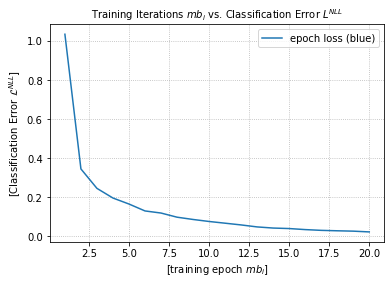

In [100]:
plot_epoch_losses(train_epoch_losses)

Load the parameters of the best model from model directory, and 
get prepared for predictions.

In [101]:
# choose the parameters in the last epoch as the parameters for the best model
best_model_epoch = num_epochs - 1

# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'EUROSAT_model_epoch_%d.pth'%best_model_epoch)

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = ResNet(resnet50_config, output_dim)

# load pre-trained models
best_model.load_state_dict(state_dict_best)

<All keys matched successfully>

In [102]:
print('EUROSAT_model_epoch_%d.pth'%best_model_epoch)

EUROSAT_model_epoch_19.pth


### 7.2.4 Prediction on validation dataset

Set the model in the evaluation mode so that the batch normalization layers are in evaluation mode in our case. Failing to do this will yield inconsistent inference results (Pytorch, 2019).

In [103]:
# set model in evaluation mode
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Load the validation data to dataloader.

In [104]:
# split the validation by mini batch size
eurosat_eval_dataloader = torch.utils.data.DataLoader(eurosat_split_val, batch_size=mini_batch_size, shuffle=False)

# the number of batches of the validation set
print("[LOG] Total number of batches in the dataloader: %d" %len(eurosat_eval_dataloader))

[LOG] Total number of batches in the dataloader: 169


Do the examinations of our trained model and calculate the test loss for validation set.


In [105]:
# init collection of mini-batch losses
eval_mini_batch_losses = []

#turn off gradients computation
with torch.no_grad():

  # iterate over all-mini batches
  for i, (images, labels) in enumerate(eurosat_eval_dataloader):

      # run forward pass through the network
      output = best_model(images.float())

      # determine classification loss
      loss = nll_loss(output[0], labels)

      # collect mini-batch reconstruction loss
      eval_mini_batch_losses.append(loss.data.item())

  # determine mean min-batch loss of epoch
  eval_loss = np.mean(eval_mini_batch_losses)

  # print epoch loss
  now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
  print('[LOG {}] eval-loss: {}'.format(str(now), str(eval_loss)))

[LOG 20220522-17:04:12] eval-loss: 0.10935659832376216


Select a sample image id from validation set and compare the true label and prediction label.

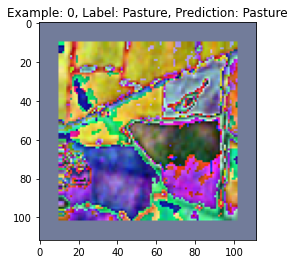

In [106]:
# select a sample image id
image_id = 0
selected_bands = [0, 1, 2]

# obtain the image from the dataloader
eurosat_eval_image = iter(eurosat_eval_dataloader).next()[0][image_id]

# obtain the true label of the image
label = eurosat_split_val[image_id][1]

# obtain the model's class prediction
prediction = torch.argmax(best_model(eurosat_eval_image.unsqueeze(0).float())[0], dim=1).item()

# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}, Prediction: {}'.format(str(image_id), str(eurosat_classes[label]), str(eurosat_classes[prediction])))

# un-normalize image sample
eurosat_eval_image_plot = eurosat_eval_image / 2.0 + 0.5

# plot image sample
plt.imshow(trans(eurosat_eval_image_plot[selected_bands,:,:]))

Make predictions on validation set using the trained model (`best_model`)

In [107]:
# init collection of mini-batch losses
predictions = []

# iterate over all-mini batches
for i, (images, labels) in enumerate(eurosat_eval_dataloader):

    # run forward pass through the network
    output = best_model(images.float())

    # collect predictons
    #batch_predictions = torch.argmax(output, dim=1)
    batch_predictions = torch.argmax(output[0], dim=1)

    # print log each 100 evaluation mini-batch
    if i % 100 == 0:

      # print mini-batch loss loss
      now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
      # multiply the number of mini-batches (i) by their size (8 images per mini-batch)
      print('[LOG {}] {} prediction(s) collected'.format(str(now), str(i*8)))

    # collect mini-batch reconstruction loss
    predictions.extend(batch_predictions.detach().numpy().tolist())

print('\nTotal predictions: {}'.format(len(predictions)))

[LOG 20220522-17:04:13] 0 prediction(s) collected
[LOG 20220522-17:05:42] 800 prediction(s) collected

Total predictions: 5400


Calculate the accuracy rate by ratio of correct predications.

In [108]:
# calculate the accuracy
eurosat_val_target = []
for i in range(5400):
  eurosat_val_target.append(eurosat_split_val[i][1])
accuracy_score = metrics.accuracy_score(eurosat_val_target, predictions)

# print the accuracy score
print(f"The metrics accuracy score for the validation set is {accuracy_score}")

The metrics accuracy score for the validation set is 0.9675925925925926


Show the confusioin matrix of the predicted and target classes of the validation set.

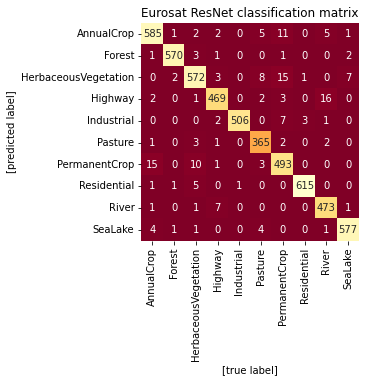

In [109]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(eurosat_val_target, predictions)

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=eurosat_classes, yticklabels=eurosat_classes)
plt.title('Eurosat ResNet classification matrix')
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

## 7.3 Model Training on all training (100%) and test dataset

###7.3.1 Set up model, hyperparameters and functions

Similar to 7.2.1, we initiate the resnet model again from scratch and load pre-trained parameters.

In [110]:
resnet_model = ResNet(resnet50_config, output_dim)

Copy the parameters of the pretrained ResNet50 model to our architecture.

In [111]:
resnet_model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

Load the ResNet50 model to device.

In [112]:
resnet_model = resnet_model.to(device)

Define learning rate and optimizer.

In [113]:
# define learning rate and optimization strategy
learning_rate = 0.001
optimizer = optim.SGD(params=resnet_model.parameters(), lr=learning_rate)

### 7.3.2 Load training data to dataloader

Load training data (100%) to data loader.

In [114]:
# automatic batching
eurosat_train_dataloader = torch.utils.data.DataLoader(eurosat_train, batch_size=mini_batch_size, shuffle=True)

# check the total number of batches
print("[LOG] Total number of batches in the dataloader: %d" %len(eurosat_train_dataloader))

[LOG] Total number of batches in the dataloader: 844


###7.3.3 Model training

Start training.

In [115]:
train_epoch_losses = []
training_model(eurosat_train_dataloader,nll_loss,optimizer,num_epochs)

[LOG 20220522-17:07:37] epoch: 1 train-loss: 0.9073915947140393
[LOG 20220522-17:08:32] epoch: 2 train-loss: 0.29978653051453463
[LOG 20220522-17:09:27] epoch: 3 train-loss: 0.22143889509000203
[LOG 20220522-17:10:23] epoch: 4 train-loss: 0.1735773477813679
[LOG 20220522-17:11:18] epoch: 5 train-loss: 0.14647873017442595
[LOG 20220522-17:12:13] epoch: 6 train-loss: 0.11987688918090403
[LOG 20220522-17:13:08] epoch: 7 train-loss: 0.0997891480906456
[LOG 20220522-17:14:03] epoch: 8 train-loss: 0.08965000243619155
[LOG 20220522-17:14:58] epoch: 9 train-loss: 0.07561539455926072
[LOG 20220522-17:15:53] epoch: 10 train-loss: 0.0640957327449244
[LOG 20220522-17:16:48] epoch: 11 train-loss: 0.055077810413137925
[LOG 20220522-17:17:43] epoch: 12 train-loss: 0.04521932065849947
[LOG 20220522-17:18:38] epoch: 13 train-loss: 0.03906203032928073
[LOG 20220522-17:19:33] epoch: 14 train-loss: 0.03677179121317991
[LOG 20220522-17:20:28] epoch: 15 train-loss: 0.033967823559121486
[LOG 20220522-17:21:2

Throughout visualization of epoch losses, we are able to check the trends of losses in each epoch.

In [116]:
# get the train loss in the training set
train_epoch_losses

# print the losses
i = 1
for item in train_epoch_losses:
  print(f"[LOG]: The train-loss for epoch {i} is {item}.")
  i +=1

[LOG]: The train-loss for epoch 1 is 0.9073915947140393.
[LOG]: The train-loss for epoch 2 is 0.29978653051453463.
[LOG]: The train-loss for epoch 3 is 0.22143889509000203.
[LOG]: The train-loss for epoch 4 is 0.1735773477813679.
[LOG]: The train-loss for epoch 5 is 0.14647873017442595.
[LOG]: The train-loss for epoch 6 is 0.11987688918090403.
[LOG]: The train-loss for epoch 7 is 0.0997891480906456.
[LOG]: The train-loss for epoch 8 is 0.08965000243619155.
[LOG]: The train-loss for epoch 9 is 0.07561539455926072.
[LOG]: The train-loss for epoch 10 is 0.0640957327449244.
[LOG]: The train-loss for epoch 11 is 0.055077810413137925.
[LOG]: The train-loss for epoch 12 is 0.04521932065849947.
[LOG]: The train-loss for epoch 13 is 0.03906203032928073.
[LOG]: The train-loss for epoch 14 is 0.03677179121317991.
[LOG]: The train-loss for epoch 15 is 0.033967823559121486.
[LOG]: The train-loss for epoch 16 is 0.02920863159984059.
[LOG]: The train-loss for epoch 17 is 0.02726516219753092.
[LOG]: T

Plot losses for each epoch. Similar to the 80% training data, the train losses become flat when approaching 20 epoches.

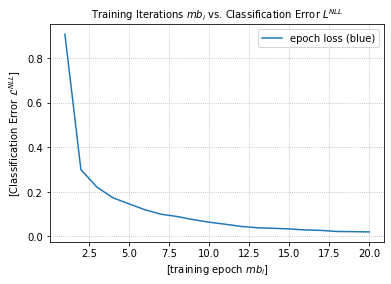

In [117]:
plot_epoch_losses(train_epoch_losses)

Load the parameters of the best model from model directory, and 
get prepared for predictions.

In [118]:
# choose the parameters in the last epoch as the parameters for the best model
best_model_epoch = num_epochs - 1

# restore pre-trained model snapshot
best_model_name = os.path.join(models_directory, 'EUROSAT_model_epoch_%d.pth'%best_model_epoch)

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = ResNet(resnet50_config, output_dim)

# load pre-trained models
best_model.load_state_dict(state_dict_best)

<All keys matched successfully>

### 7.3.4 Prediction on test dataset

Set the model in the evaluation mode.

In [119]:
# set model in evaluation mode
best_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Load test data into dataloader.

In [120]:
# load evaluation and split by mini batch size
eurosat_eval_dataloader = torch.utils.data.DataLoader(eurosat_test, batch_size=mini_batch_size, shuffle=False)

# check the number of batches
print("[LOG] Total number of batches in the dataloader: %d" %len(eurosat_eval_dataloader))

[LOG] Total number of batches in the dataloader: 133


View a single image in the Kaggle test dataset. Visionally, this image has the same style as images in the training data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


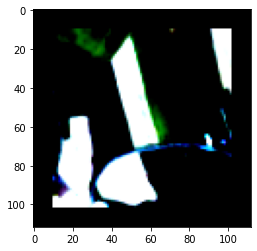

In [121]:
# view a single image
plt.imshow(eurosat_test[3][[0,1,2],:,:].permute(1, 2, 0))

Select a sample image from the test dataloader.

In [122]:
eurosat_eval_image = iter(eurosat_eval_dataloader).next()[4]

Check the prediction label of the sample image from the test dataloader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


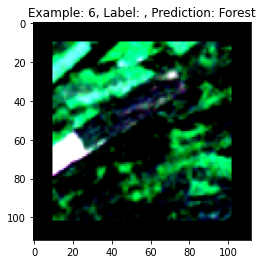

In [123]:
# select a sample image id
image_id = 6


# obtain the image from the dataloader
eurosat_eval_image = iter(eurosat_eval_dataloader).next()[image_id]

# obtain the true label of the image
label = "no idea"

# obtain the model's class prediction
prediction = torch.argmax(best_model(eurosat_eval_image.unsqueeze(0).float())[0], dim=1).item()

# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title 
plt.title('Example: {}, Label: {}, Prediction: {}'.format(str(image_id), str(), str(eurosat_classes[prediction])))

# un-normalize cifar 10 image sample
eurosat_eval_image_plot = eurosat_eval_image/ 2.0 + 0.5

# plot eurosat image sample
plt.imshow(eurosat_eval_image_plot[[0,1,2],:,:].permute(1,2,0))

Make predictions on test set using the trained model (`best_model`)

In [124]:
# init collection of mini-batch losses
predictions = []

# turn off gradients computation
with torch.no_grad():

  # iterate over all-mini batches
  for i, images in enumerate(eurosat_eval_dataloader):

      # run forward pass through the network
      output = best_model(images.float())

      # collect predictons
      batch_predictions = torch.argmax(output[0], dim=1)

      # print log each 100 evaluation mini-batch
      if i % 100 == 0:

        # print mini-batch loss loss
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        # multiply the number of mini-batches (i) by their size (8 images per mini-batch)
        print('[LOG {}] {} prediction(s) collected'.format(str(now), str(i*8)))

      # collect mini-batch reconstruction loss
      predictions.extend(batch_predictions.detach().numpy().tolist())

  print('\nTotal predictions: {}'.format(len(predictions)))

[LOG 20220522-17:25:06] 0 prediction(s) collected
[LOG 20220522-17:26:32] 800 prediction(s) collected

Total predictions: 4232


Create the labels list for preditions, add the predicted labels into the list.

In [125]:
# create a list for predicted labels
predictions_of_labels = []

# match the predicted label indexes and the labels from classes, add the labels in to the list
for index in range(4232):
  predictions_of_labels.append(eurosat_classes[predictions[index]])

Show the first 10 predictions.

In [126]:
# show the first 10 predictions
predictions_of_labels[0:9]

['Forest',
 'Highway',
 'SeaLake',
 'AnnualCrop',
 'River',
 'River',
 'Forest',
 'AnnualCrop',
 'River']

In [127]:
# check if all images get predictions
print("The number of predicted labels is: %d"%len(predictions_of_labels))

The number of predicted labels is: 4232


Plot the distributions of the predicted labels.

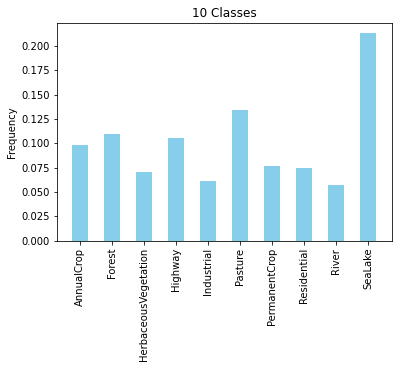

In [128]:
plot_label_dist(predictions_of_labels, "10 Classes")

Create a dataframe for submission to Kaggle.

In [129]:
prediction_for_submission = pd.DataFrame(
    {'test_id': test_id,
     'label': predictions_of_labels
    })

Sort the predicted values according to test id.

In [130]:
prediction_for_submission = prediction_for_submission.sort_values(by=['test_id'])

Check the first 20 values of our prediction.

In [131]:
prediction_for_submission.head(20)

test_id                 label
1215        0               Pasture
3267        1                 River
2366        2         PermanentCrop
3110        3                Forest
3071        4                 River
4118        5            AnnualCrop
1130        6               SeaLake
3786        7               SeaLake
1310        8  HerbaceousVegetation
3594        9            AnnualCrop
1012       10               SeaLake
2883       11               SeaLake
303        12  HerbaceousVegetation
529        13            Industrial
1657       14               Pasture
1261       15                Forest
1883       16               SeaLake
3646       17                 River
3699       18            AnnualCrop
26         19                 River

Save the label predictions of the test data as csv into Google Drive.

In [132]:
# save csv file to notebook_directory
submission_dir = os.path.join(notebook_directory, "submission-file-boringfinance.csv")
prediction_for_submission.to_csv(submission_dir, columns=["test_id","label"],index=False)

# Appendix

## Explore the Learning Rate

An improvement of pre-trained model is fine tunning, which applys different learning rates on each epoch when training the ResNet model. 

Here we try to use `LRScheduler` to search for the best learning rate that decays exponentially if we do fine tunning, given our pre-trained ResNet50 setting.

In the meantime, we would like to check if our pre-trained ResNet50 employs a good learning rate.

In [133]:
from torch.optim.lr_scheduler import _LRScheduler

# construct a finder
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        # pretrained ResNet50 setting
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    # calculate the train loss on the splitted target range
    def range_test(self, iterator, end_lr = 10, num_iter = 1000, 
                   smooth_f = 0.05, diverge_th = 5):
        
        # learning rates
        lrs = []

        # train losses corresponding to learning rates
        losses = []

        # the minimal loss
        best_loss = float('inf')

        # test if the learning rate decays exponentially every epoch.
        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        # iterate
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            # initial loss
            loss = self._train_batch(iterator)

            # update lr
            lr_scheduler.step()
            
            # add the next learning rate
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:

                # smooth the loss
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:

                # update the minimal loss
                best_loss = loss
            
            # store the minimal loss
            losses.append(loss)
            
            # if diverged, stop
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        resnet_model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        # train the model
        self.model.train()
        
        # set the gradients to 0 before backpropragation
        self.optimizer.zero_grad()
        
        # iterate to the next batch
        x, y = iterator.get_batch()
        
        x = x.float().to(self.device)
        y = y.to(self.device)
        
        # get the prediction of this batch
        y_pred, _ = self.model(x)
        
        # calcualte the loss given the loss function
        loss = self.criterion(y_pred, y)
        
        # backpropragation
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

# let the tested learning rate decays exponentially for each epoch
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        # get current epoch
        curr_iter = self.last_epoch + 1

        # return the list of scheduled learing rates
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

# an iterator object to the next batch
class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

Set the start and the end points for the range to search for the best learning rate, the number of intervals and the optimizer. 

In [134]:
# define learning rate and optimization strategy
learning_rate = 0.0001 # the start point of learning rates to search
optimizer_name = "SGD"
optimizer = optim.SGD(params=resnet_model.parameters(), lr=learning_rate)
end_lr = 10
num_iter = 100

Under the setting of pre-trained ResNet50 and 100% EuroSAT training data, calculate the train losses for all learning rates.

In [135]:
# reset the model
resnet_model = ResNet(resnet50_config, output_dim)
resnet_model.load_state_dict(pretrained_model.state_dict())
resnet_model = resnet_model.to(device)

# reset the dataloader
eurosat_train_dataloader = torch.utils.data.DataLoader(eurosat_train, batch_size=mini_batch_size, shuffle=True)

# calculate train losses
lr_finder = LRFinder(resnet_model, optimizer, nll_loss, device)
lrs, losses = lr_finder.range_test(eurosat_train_dataloader, end_lr, num_iter)

Stopping early, the loss has diverged


Find and Print the best learning rate and the corresponding minimal train loss. 

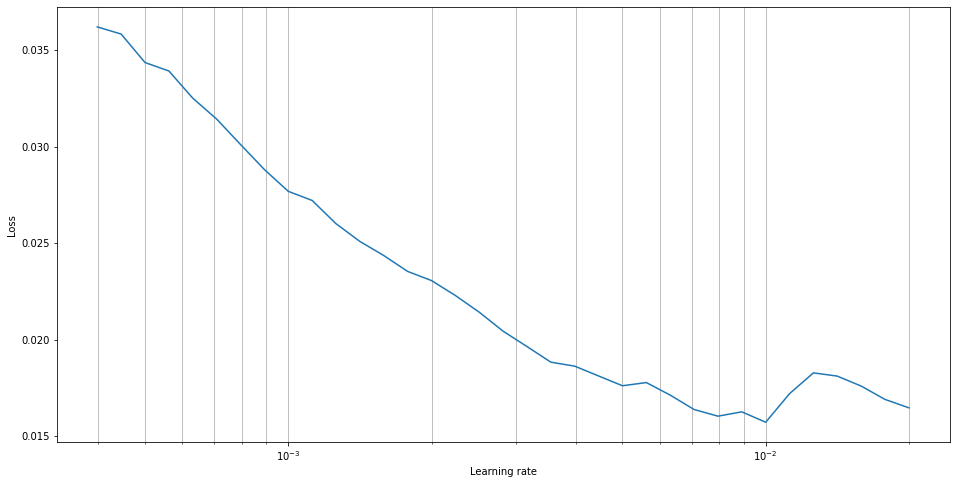

The best learning rate if decaying exponentially is: 0.0100
The train loss crorrespondingly is: 0.0157


In [137]:
# print the minimal point and the best learning rate
min_lr, min_loss = plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 10)

print("The best learning rate if decaying exponentially is: %.4f" % min_lr)
print("The train loss crorrespondingly is: %.4f" % min_loss)

#References

Alfrick Opidi, A. J. (2022, April 20th). PyTorch Loss Functions: The Ultimate Guide. Retrieved from Neptune Blog: https://neptune.ai/blog/pytorch-loss-functions \\
Balduzzi, D., Frean, M., Leary, L., Lewis, J. P., Ma, K. W. D., & McWilliams, B. (2017, July). The shattered gradients problem: If resnets are the answer, then what is the question?. In International Conference on Machine Learning (pp. 342-350). PMLR. Retrieved from https://arxiv.org/abs/1702.08591 \\
Borth, D. (2022). Machine Learning. Lecture Slides. HSG. \\
He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778). Retrieved from https://ieeexplore.ieee.org/document/7780459 \\
Huang, C. (2019 , November 13). Pytorch101: Data Preprocessing and Augmentation (Part 1). Retrieved from choles blog: https://chloes-dl.com/2019/11/13/pytorch101-data-preprocessing-and-augmentation-part-1/ \\
Mikołajczyk, A., & Grochowski, M. (2018, May). Data augmentation for improving deep learning in image classification problem. In 2018 international interdisciplinary PhD workshop (IIPhDW) (pp. 117-122). IEEE. Retrieved from https://ieeexplore.ieee.org/document/8388338 \\
Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., … Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. In Advances in Neural Information Processing Systems 32 (pp. 8024–8035). Curran Associates, Inc. Retrieved from http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf \\
Pedro Marcelino(2018). Transfer learning from pre-trained models. Retried from https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751 \\
Torch Contributors. PyTorch Documentation. Retrieved from https://pytorch.org/docs/stable/index.html \\
Torch Contributors. Torchvision Documentation. Retrieved from 
https://pytorch.org/vision/stable/transforms.html \\

### Code

amrzv’s ResNet Tutorial: https://github.com/bentrevett/pytorch-image-classification/blob/master/5_resnet.ipynb \\
HSG-AIML-Teaching’s Course Code Lab: https://colab.research.google.com/github/HSG-AIML-Teaching/ML2022-Lab/blob/main/lab_3_5/colab_03-5.ipynb